In [5]:
from neo4j import GraphDatabase
from branca.colormap import LinearColormap
import folium
import geopandas as gpd 
import matplotlib as plt
import matplotlib.pyplot as pyplot
import branca.colormap as cm

In [6]:
url = "bolt://neo4j"
username = "neo4j"
password = "admin"

driver = GraphDatabase.driver(url, auth=("neo4j", "admin"), encrypted=False)

# From Mongo to Neo4j

In [7]:
query = """
    MATCH (n) detach delete n
"""
with driver.session() as session:
    session.run(query)
    print("Esecuzione della query completata")

Esecuzione della query completata


In [8]:
query = """
    CALL apoc.mongo.find('mongodb://mongo:27017/mydb.polygons', {name: 'anderlecht'}) YIELD value 
    WITH value.streets AS streets 
    UNWIND range(0, 100) AS street_id 
    WITH streets[street_id] AS current, street_id
    UNWIND range(0, size(current.coords) - 2) AS coord_id 
    WITH current.coords[coord_id] AS current_c, current.coords[coord_id + 1] AS next_c, street_id
    MERGE (c1:Coordinate {latitude: current_c[1], longitude: current_c[0]}) 
    MERGE (c2:Coordinate {latitude: next_c[1], longitude: next_c[0]}) 
    MERGE (c1)-[n:NEXT]->(c2) ON CREATE SET n.street_id = street_id ON MATCH SET n.street_id = street_id
"""
with driver.session() as session:
    session.run(query)
    print("Esecuzione della query completata")

Esecuzione della query completata


### Get traffic info by month

In [10]:
collection = "anderlecht-period-1"
date = "2019-01" 

In [11]:
query = f"""
    CALL apoc.mongo.find('mongodb://mongo:27017/mydb.{collection}') yield value
    UNWIND value AS street
    MATCH (n1)-[r:NEXT]->(n2)
    WHERE r.street_id = street.id
    SET r.traffic = [event IN street.events WHERE event.date = '{date}' | event][0].traffic_sum
    SET r.date = '{date}'
"""
with driver.session() as session:
    session.run(query)
    print("Esecuzione della query completata")

Esecuzione della query completata


### Get traffic info by day

In [13]:
collection = "anderlecht-period-1"
month = "2019-01" 
day = "2019-01-01"

In [14]:
query = f"""
    CALL apoc.mongo.find('mongodb://mongo:27017/mydb.{collection}') yield value
    UNWIND value AS street
    MATCH (n1)-[r:NEXT]->(n2)
    WHERE r.street_id = street.id
    WITH r, street, [event IN street.events WHERE event.date = '{month}' | event][0] as month
    WITH r, street, [event IN month.events WHERE event.date = '{day}' | event][0] as day
    SET r.traffic = day.traffic_sum
    SET r.velocity = day.velocity_mean
"""
with driver.session() as session:
    session.run(query)
    print("Esecuzione della query completata")

Esecuzione della query completata


## Map of streets only

In [6]:
query = """
    MATCH (c1:Coordinate)-[n:NEXT]->(c2:Coordinate)
    RETURN c1.latitude AS c1_lat, c1.longitude AS c1_lon, c2.latitude AS c2_lat, c2.longitude AS c2_lon
"""
with driver.session() as session:
    result = session.run(query)
    coordinates = [(record["c1_lat"], record["c1_lon"], record["c2_lat"], record["c2_lon"]) for record in result]


In [ ]:
m = folium.Map(location=[50.832697, 4.294337], zoom_start=14, tiles='cartodbpositron', control_scale=True, zoom_control=False, dragging=False, scrollWheelZoom=False)  # Imposta la posizione e lo zoom iniziale della mappa
for coords in coordinates:
    folium.PolyLine([(coords[0], coords[1]), (coords[2], coords[3])], color="blue").add_to(m)
m

## Map of streets with traffic

In [15]:
query = """
    MATCH (c1:Coordinate)-[n:NEXT]->(c2:Coordinate)
    WHERE n.traffic is not null
    RETURN c1.latitude AS c1_lat, c1.longitude AS c1_lon, c2.latitude AS c2_lat, c2.longitude AS c2_lon, n.traffic as traffic
"""
with driver.session() as session:
    result = session.run(query)
    traffic = [(record["c1_lat"], record["c1_lon"], record["c2_lat"], record["c2_lon"], record["traffic"]) for record in result]
    print("Esecuzione della query completata")

Esecuzione della query completata


In [16]:
colormap_dept = cm.StepColormap(
    colors=['#00ae53', '#bfd947', '#f1c232',
            '#f6b26b', '#ee7b15', '#ee0028'],
    vmin = 1,
    vmax = 10,
    index=[0, 2, 4, 6, 8, 10 ])

def get_color(value):
    if value < 2:
        return '#00ae53'
    elif value < 4:
        return '#bfd947'
    elif value < 6:
        return '#f1c232'
    elif value < 8:
        return '#f6b26b'
    elif value < 10:
        return '#ee7b15'
    else:
        return '#ee0028'

In [17]:
m = folium.Map(location=[50.832697, 4.294337], zoom_start=14, tiles='cartodbpositron',  control_scale=True, zoom_control=False, dragging=False, scrollWheelZoom=False)
for coords in traffic:
    color = get_color(coords[4])
    folium.PolyLine([(coords[0], coords[1]), (coords[2], coords[3])], color=color, weight=3).add_to(m)

colormap_dept.caption = 'Traffico'
colormap_dept.add_to(m)
m

## Analysis

In [18]:
with driver.session() as session:
    result = session.run("MATCH (:Coordinate)-[r:NEXT]->(:Coordinate) WHERE r.traffic is not null RETURN r.traffic AS traffic")
    traffic_values = [record["traffic"] for record in result]

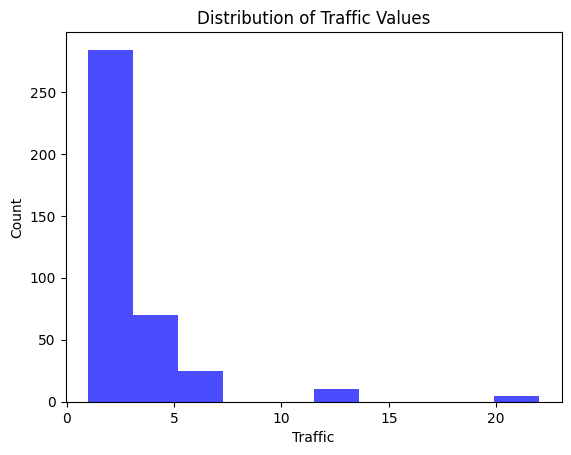

In [19]:
pyplot.hist(traffic_values, bins=10, alpha=0.7, color='b')
pyplot.xlabel("Traffic")
pyplot.ylabel("Count")
pyplot.title("Distribution of Traffic Values")
pyplot.show()